In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sinter
from relay_bp.stim import SinterDecoder_MemBP

from pathlib import Path
import sys
sys.path.append(str(Path("..").resolve()))

from rotated_surface_code import RotatedSurfaceCode
import os

In [ ]:
p = 0.003
gamma0_candidate_list = np.arange(0, 1.01, 0.05).tolist()

tasks = []
for d in [5, 7, 9, 11]:
    code = RotatedSurfaceCode(d=d)
    circuit = code.make_circuit_memory_z_experiment( # full circuit-level noise
        rounds=d,
        data_qubit_error_rate=p,
        prep_error_rate=p,
        meas_error_rate=p,
        gate1_error_rate=p,
        gate2_error_rate=p,
        keep_z_detectors_only=True,
    )
    for gamma0 in gamma0_candidate_list:
        tasks.append(
            sinter.Task(
                circuit=circuit,
                decoder='mem-bp(gamma0={})'.format(gamma0),
                json_metadata={
                    'p': p,
                    'd': d,
                    'rounds': d,
                    'gamma0': gamma0,
                }
            )
        )

collected_stats = sinter.collect(
    num_workers=os.cpu_count() - 1,
    tasks=tasks,
    custom_decoders={
        'mem-bp(gamma0={})'.format(gamma0): SinterDecoder_MemBP(max_iter=100, parallel=True, gamma0=gamma0)
        for gamma0 in gamma0_candidate_list
    },
    max_shots=500_000,
    max_errors=50,
    print_progress=True,
)

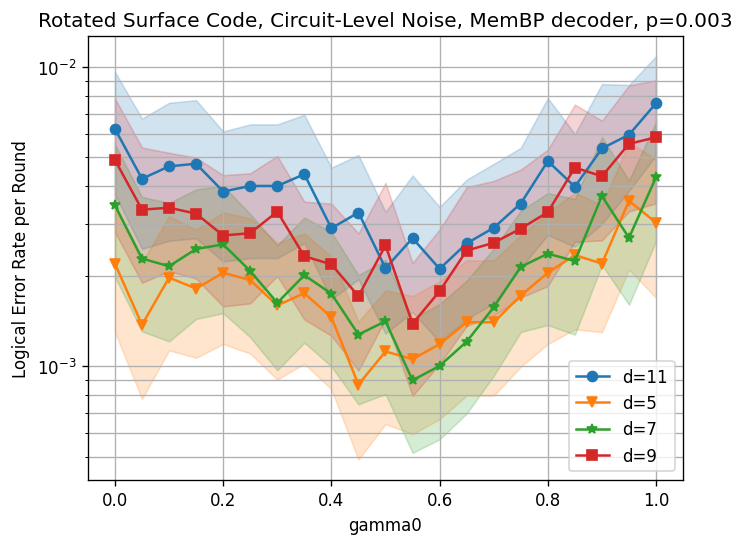

In [3]:
# Plot the error rate vs. physical error rate
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['gamma0'],
    group_func=lambda stats: dict(
        label="d={}".format(stats.json_metadata['d'])
    ),
    failure_units_per_shot_func=lambda stats: stats.json_metadata['rounds'],
)
ax.semilogy()
ax.set_title("Rotated Surface Code, Circuit-Level Noise, MemBP decoder, p={}".format(p))
ax.set_xlabel("gamma0")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger